# import & setting

In [175]:
from datetime import datetime as dt
from tqdm import tqdm

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import VotingRegressor,RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse

import warnings


In [2]:
warnings.filterwarnings('ignore') # 경고 미출력

pd.set_option('display.float_format', '{:.2f}'.format) # 판다스 소수점 표시형식 설정

# matplotlib 한글 표시
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if  platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    print('Windows version')

Windows version


# load data

In [3]:
train = pd.read_csv('movies_train.csv')
test = pd.read_csv('movies_test.csv')
sub = pd.read_csv('submission.csv')

In [4]:
print(train.shape,test.shape)
print(train.info())

(600, 12) (243, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB
None


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [6]:
train.describe(include=np.object_)

,title,distributor,genre,release_time,screening_rat,director
count,600,600,600,600,600,600
unique,600,169,12,330,4,472
top,개들의 전쟁,CJ 엔터테인먼트,드라마,2015-10-22,청소년 관람불가,홍상수
freq,1,54,221,6,204,7


In [7]:
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.00,270.00,600.00,600.00,600.00,600.00
mean,100.86,1050442.89,0.88,151.12,3.71,708181.75
std,18.10,1791408.30,1.18,165.65,2.45,1828005.85
min,45.00,1.00,0.00,0.00,0.00,1.00
25%,89.00,20380.00,0.00,17.00,2.00,1297.25
50%,100.00,478423.62,0.00,82.50,3.00,12591.00
75%,114.00,1286568.62,2.00,264.00,4.00,479886.75
max,180.00,17615314.00,5.00,869.00,25.00,14262766.00


In [8]:
test.describe(include=np.object_)

,title,distributor,genre,release_time,screening_rat,director
count,243,243,243,243,243,243
unique,243,93,12,182,4,220
top,용서는 없다,CJ 엔터테인먼트,드라마,2015-09-10,청소년 관람불가,조성규
freq,1,31,78,4,93,3


In [9]:
test.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,243.00,107.00,243.00,243.00,243.00
mean,109.80,891669.52,0.85,159.32,3.48
std,124.02,1217341.45,1.20,162.98,2.11
min,40.00,34.00,0.00,0.00,0.00
25%,91.00,62502.00,0.00,18.00,2.00
50%,104.00,493120.00,0.00,105.00,3.00
75%,114.50,1080849.58,1.00,282.00,4.00
max,2015.00,6173099.50,6.00,776.00,16.00


# data preprocessing

In [10]:
# 의미없는 데이터인 title 컬럼 삭제
train.drop(['title','director'],axis=1,inplace=True)
test.drop(['title','director'],axis=1,inplace=True)

## 결측치 처리

In [11]:
# na -> 0

train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

## 개봉일 데이터 전처리

### 개봉일 데이터 타입 변환

In [12]:
# object -> datetime
train['release_time_dt'] = pd.to_datetime(train.release_time)
test['release_time_dt'] = pd.to_datetime(test.release_time)

### 연, 월 데이터만 추출하여 그룹핑

In [13]:
train['r_time_y']=train['release_time_dt'].dt.year
train['r_time_m']=train['release_time_dt'].dt.month

test['r_time_y']=test['release_time_dt'].dt.year
test['r_time_m']=test['release_time_dt'].dt.month

In [14]:
tt=train[['r_time_y','r_time_m','box_off_num']].groupby(['r_time_y','r_time_m']).sum().reset_index()

### 월 별로 관람객 수의 차이가 있는지 그래프를 통해 확인

100%|██████████| 6/6 [00:00<00:00, 14.71it/s]


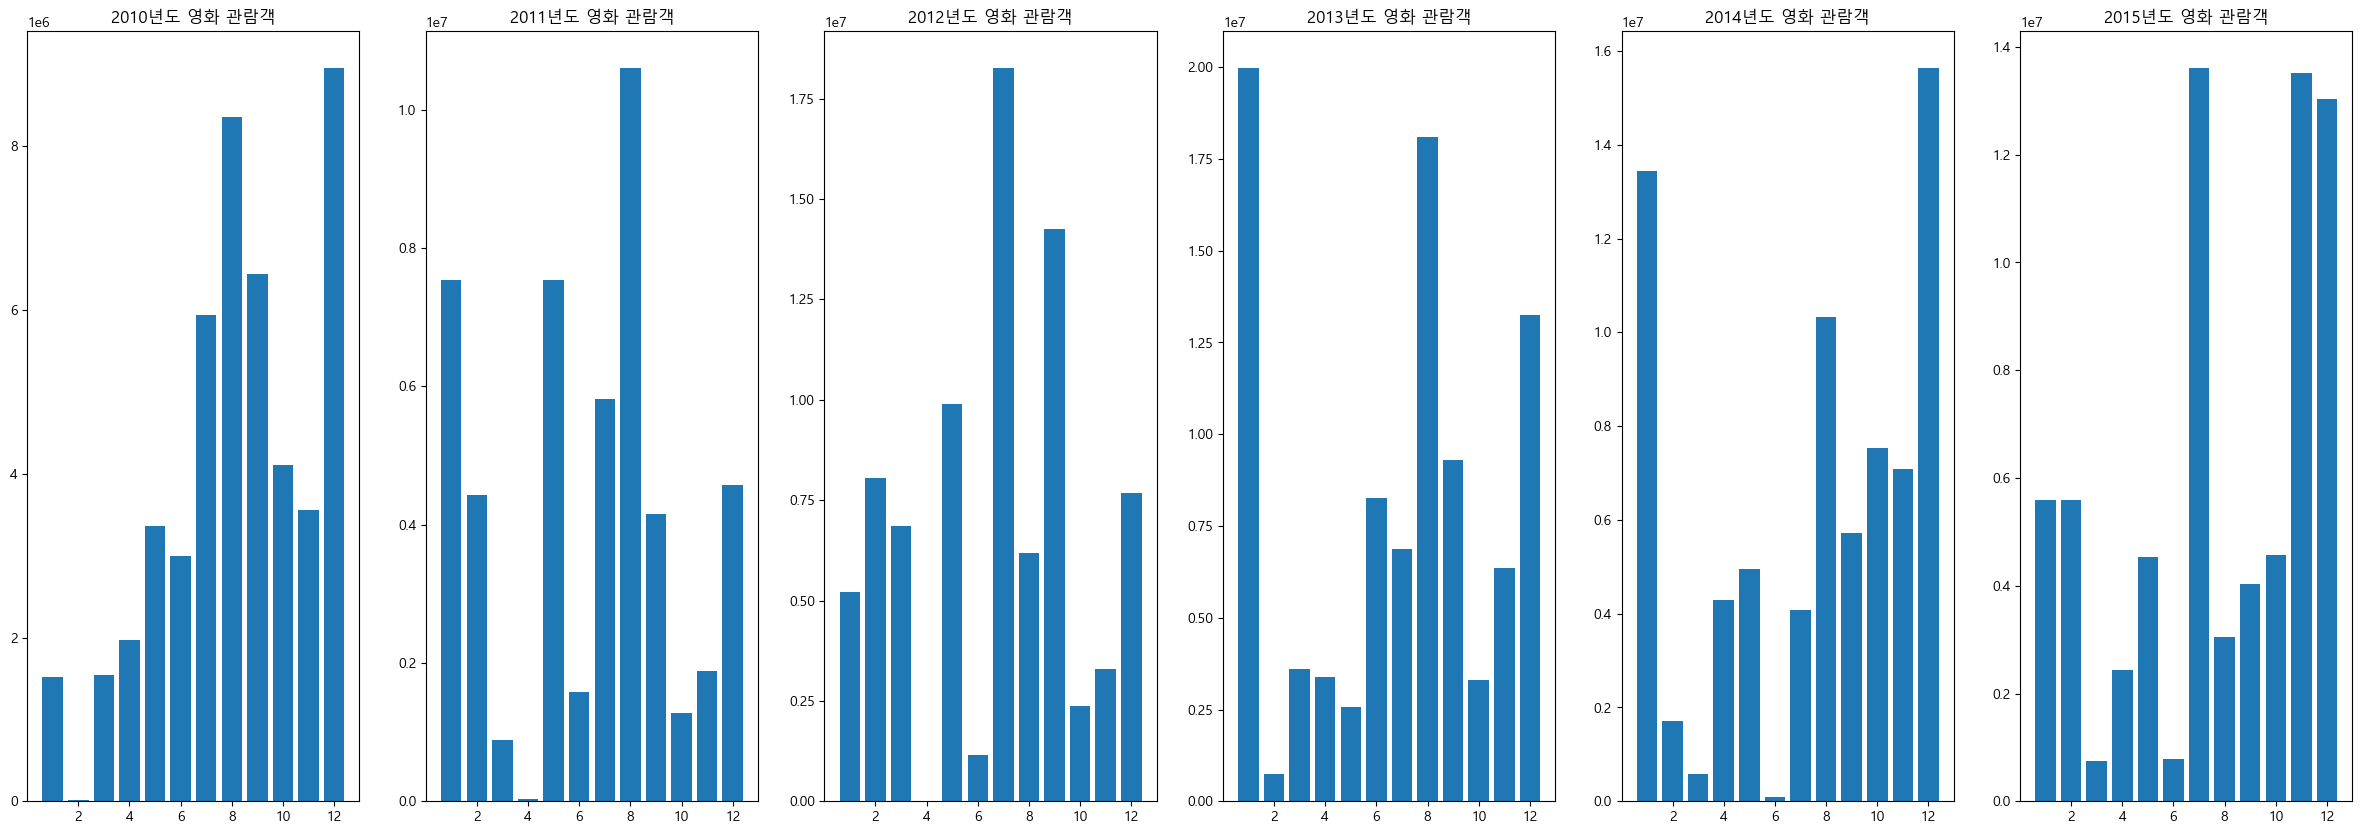

In [15]:
i=1
plt.figure(figsize=(30,10))
for k, group in tqdm(tt.groupby('r_time_y')):
    plt.subplot(1,6,i) 
    plt.title(str(k)+"년도 영화 관람객")
    x = group['r_time_m']
    y = group['box_off_num']
    plt.bar(x,y)
    i+=1
plt.show()

<BarContainer object of 600 artists>

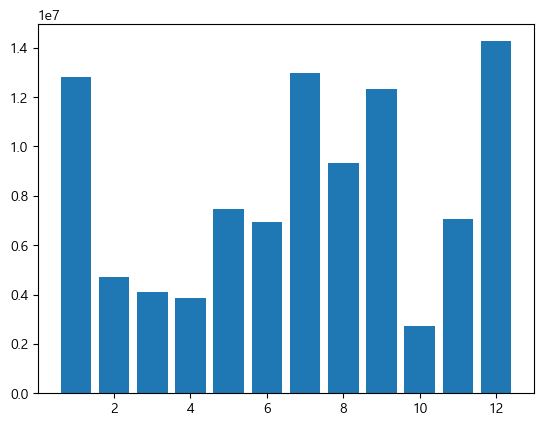

In [16]:
plt.bar(train.r_time_m,train['box_off_num'])

### 타겟 인코딩을 통해 개봉년도, 월 별 관람객의 중위값을 파생변수로 생성

In [17]:
tt2=tt.groupby('r_time_m').median()[['box_off_num']].sort_values('box_off_num',ascending=False).reset_index().rename(columns={'box_off_num':'month_num'})

In [18]:
tt2

,r_time_m,month_num
0,12,10998142.00
1,8,9338054.00
2,1,6564968.00
3,7,6402375.00
4,9,6076700.00
5,11,4952603.00
6,5,4737722.00
7,10,3704727.50
8,2,3071228.50
9,4,2203071.50


In [19]:
train=train.merge(tt2,how='left')

test = test.merge(tt2,how='left')

In [20]:
train.head(2)

,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,release_time_dt,r_time_y,r_time_m,month_num
0,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398,2012-11-22,2012,11,4952603.00
1,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,2015-11-19,2015,11,4952603.00


In [21]:
test.head(2)

,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,release_time_dt,r_time_y,r_time_m,month_num
0,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,300529.00,2,304,3,2010-01-07,2010,1,6564968.00
1,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,342700.25,4,275,3,2010-01-14,2010,1,6564968.00


### 파생변수 month_num을 제외한 개봉날짜 관련 컬럼 삭제

In [22]:
train=train.drop(['release_time','release_time_dt','r_time_m','r_time_y'],axis=1)
test=test.drop(['release_time','release_time_dt','r_time_m','r_time_y'],axis=1)

In [23]:
train.head(2)

,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,month_num
0,롯데엔터테인먼트,액션,96,청소년 관람불가,조병옥,0.00,0,91,2,23398,4952603.00
1,(주)쇼박스,느와르,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,4952603.00


In [24]:
test.head(2)

,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,month_num
0,시네마서비스,느와르,125,청소년 관람불가,김형준,300529.00,2,304,3,6564968.00
1,(주)쇼박스,멜로/로맨스,113,12세 관람가,이광재,342700.25,4,275,3,6564968.00


## 배급사 데이터 전처리

### 배급사 컬럼의 문자 중 쓸 데 없는 문자열 제거 및 같은 속성의 문자열 합치기

In [25]:
train['distributor'] = train.distributor.str.replace("(주)", '')
test['distributor'] = test.distributor.str.replace("(주)", '')

train['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

In [26]:
def get_dis(x) :
    if 'CJ' in x or 'CGV' in x :
        return 'CJ'
    elif '쇼박스' in x :
        return '쇼박스'
    elif 'SK' in x :
        return 'SK'
    elif '리틀빅픽' in x :
        return '리틀빅픽처스'
    elif '스폰지' in x :
        return '스폰지'
    elif '싸이더스' in x :
        return '싸이더스'
    elif '에이원' in x :
        return '에이원'
    elif '마인스' in x :
        return '마인스'
    elif '마운틴픽' in x :
        return '마운틴픽처스'
    elif '디씨드' in x :
        return '디씨드'
    elif '드림팩트' in x :
        return '드림팩트'
    elif '메가박스' in x :
        return '메가박스'
    elif '마운틴' in x :
        return '마운틴'
    else :
        return x

In [27]:
train['distributor'] = train.distributor.apply(get_dis)

test['distributor'] = test.distributor.apply(get_dis)

### 배급사 별로 관람객 수의 차이가 있는지 그래프를 통해 확인

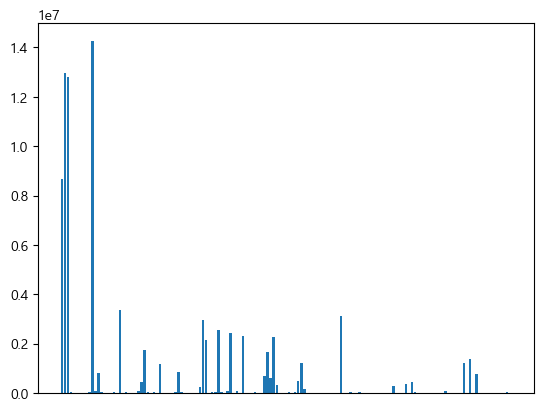

In [31]:
plt.bar(train['distributor'],train['box_off_num'])
plt.gca().axes.xaxis.set_visible(False) #x축만 없애기

### 타겟 인코딩을 통해 배급사 별 관람객의 평균값을 파생변수로 생성

In [32]:
tt3=train[['distributor','box_off_num']].groupby('distributor').mean().reset_index().rename(columns={'box_off_num':'dis_mean_num'})

In [33]:
tt3

,distributor,dis_mean_num
0,BoXoo엔터테인먼트,15572.00
1,CJ,2066505.50
2,JK필름,688639.00
3,KBS미디어,7956.00
4,KT,269278.33
...,...,...
142,하준사,600.00
143,한국YWCA연합회,71.00
144,홀리가든,1721.50
145,화앤담이엔티,172196.50


In [34]:
train=train.merge(tt3,how='left')

test=test.merge(tt3,how='left')

In [35]:
train.head(2)

,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,month_num,dis_mean_num
0,롯데엔터테인먼트,액션,96,청소년 관람불가,조병옥,0.00,0,91,2,23398,4952603.00,1238148.94
1,쇼박스,느와르,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,4952603.00,3332953.93


In [36]:
test.head(2)

,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,month_num,dis_mean_num
0,시네마서비스,느와르,125,청소년 관람불가,김형준,300529.00,2,304,3,6564968.00,896843.17
1,쇼박스,멜로/로맨스,113,12세 관람가,이광재,342700.25,4,275,3,6564968.00,3332953.93


### 파생변수 dis_mean_num을 제외한 배급사 관련 컬럼 삭제

In [37]:
train.drop('distributor',axis=1,inplace=True)

test.drop('distributor',axis=1,inplace=True)

In [41]:
train.head(2)

,genre,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,month_num,dis_mean_num
0,액션,96,청소년 관람불가,0.00,0,91,2,23398,4952603.00,1238148.94
1,느와르,130,청소년 관람불가,1161602.50,2,387,3,7072501,4952603.00,3332953.93


In [43]:
test.head(2)

,genre,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,month_num,dis_mean_num
0,느와르,125,청소년 관람불가,300529.00,2,304,3,6564968.00,896843.17
1,멜로/로맨스,113,12세 관람가,342700.25,4,275,3,6564968.00,3332953.93


## genre, screening_rat 컬럼 전처리

### 그래프를 통해 컬럼 값 별 관람객 수 확인

<BarContainer object of 600 artists>

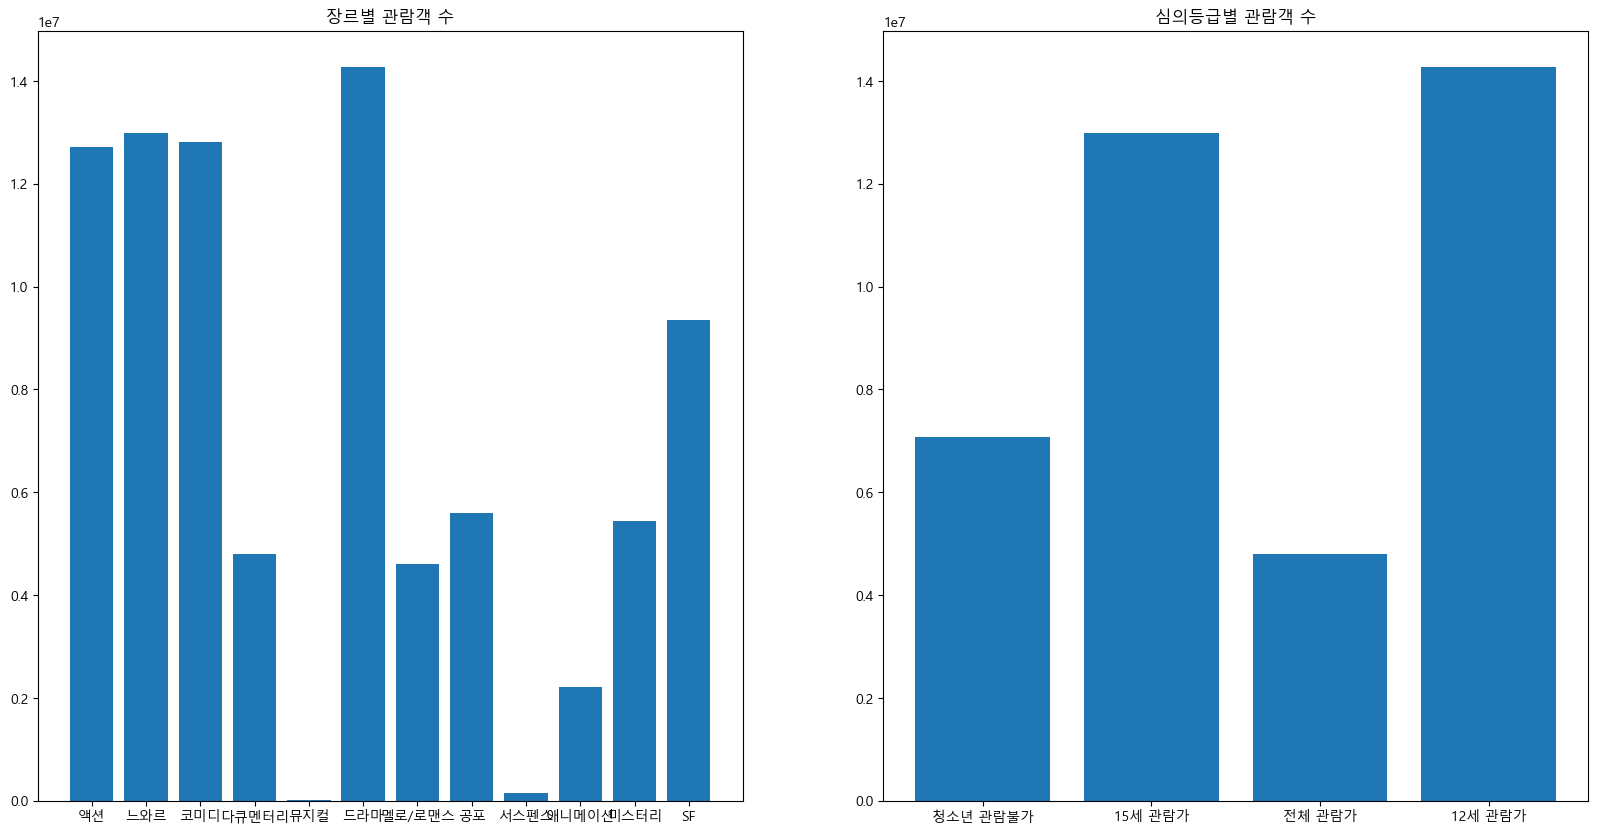

In [47]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('장르별 관람객 수')
plt.bar(train['genre'],train['box_off_num'])
plt.subplot(1,2,2)
plt.title('심의등급별 관람객 수')
plt.bar(train['screening_rat'],train['box_off_num'])

### 각 컬럼 별 관람객 수의 중위값을 이용하여 랭크인코딩(라벨 인코딩)

In [59]:
# genre
t_genre = train[['genre','box_off_num']].groupby('genre').median().sort_values('box_off_num').reset_index().reset_index().drop('box_off_num',axis=1)
t_genre['index']=t_genre['index']+1
t_genre.rename(columns={'index':'rank'},inplace=True)

# screening_rat
t_screening_rat = train[['screening_rat','box_off_num']].groupby('screening_rat').median().sort_values('box_off_num').reset_index().reset_index().drop('box_off_num',axis=1)
t_screening_rat['index'] = t_screening_rat['index']+1
t_screening_rat.rename(columns={'index':'rank_rat'},inplace=True)

display(t_genre, t_screening_rat)

,rank,genre
0,1,다큐멘터리
1,2,미스터리
2,3,멜로/로맨스
3,4,뮤지컬
4,5,드라마
5,6,SF
6,7,애니메이션
7,8,서스펜스
8,9,공포
9,10,코미디


,rank_rat,screening_rat
0,1,청소년 관람불가
1,2,전체 관람가
2,3,12세 관람가
3,4,15세 관람가


In [62]:
train=train.merge(t_genre,how='left').merge(t_screening_rat,how='left')

test=test.merge(t_genre,how='left').merge(t_screening_rat,how='left')

### 파생변수 rank, rank_rat 을 제외한 장르, 심의등급 관련 컬럼 삭제

In [64]:
train.drop(['genre','screening_rat'],axis=1, inplace=True)

test.drop(['genre','screening_rat'],axis=1, inplace=True)

In [65]:
train.head(2)

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,month_num,dis_mean_num,rank,rank_rat
0,96,0.00,0,91,2,23398,4952603.00,1238148.94,11,1
1,130,1161602.50,2,387,3,7072501,4952603.00,3332953.93,12,1


In [66]:
test.head(2)

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,month_num,dis_mean_num,rank,rank_rat
0,125,300529.00,2,304,3,6564968.00,896843.17,12,1
1,113,342700.25,4,275,3,6564968.00,3332953.93,3,3


## 최종 데이터 셋 점검

In [176]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 599
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time            600 non-null    int64  
 1   dir_prev_bfnum  600 non-null    float64
 2   dir_prev_num    600 non-null    int64  
 3   num_staff       600 non-null    int64  
 4   num_actor       600 non-null    int64  
 5   box_off_num     600 non-null    int64  
 6   month_num       600 non-null    float64
 7   dis_mean_num    600 non-null    float64
 8   rank            600 non-null    int64  
 9   rank_rat        600 non-null    int64  
dtypes: float64(3), int64(7)
memory usage: 51.6 KB


In [177]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 242
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time            243 non-null    int64  
 1   dir_prev_bfnum  243 non-null    float64
 2   dir_prev_num    243 non-null    int64  
 3   num_staff       243 non-null    int64  
 4   num_actor       243 non-null    int64  
 5   month_num       243 non-null    float64
 6   dis_mean_num    212 non-null    float64
 7   rank            243 non-null    int64  
 8   rank_rat        243 non-null    int64  
dtypes: float64(3), int64(6)
memory usage: 19.0 KB


In [178]:
test.isna().sum() # train데이터 셋에 없는 배급사 값으로 인해 na값 발생

time               0
dir_prev_bfnum     0
dir_prev_num       0
num_staff          0
num_actor          0
month_num          0
dis_mean_num      31
rank               0
rank_rat           0
dtype: int64

In [179]:
test.fillna(0, inplace=True)

In [183]:
# train 데이터의 feature, target 분리
train_x=train.drop('box_off_num',axis=1)
train_y=train[['box_off_num']]

## feature scaling, model 별 결과 비교
    1. 테스트할 모델 with GridSearchCV
        1) 단일 회귀 모델(LinearRegression, Lasso, Ridge, ElasticNet)을 이용한 Voting
        2) RandomForesetRegressor
        3) GradientBoostingRegressor
        4) XGBRegressor
        5) LGBMRegressor

        가장 rmse가 낮게 나오는 모델을 선택하여 스케일링 테스트

    2. 테스트할 스케일링
        1) StandardScaler
        2) MinMaxScaler
        3) RobustScaler

        스케일링하지 않은 데이터의 결과와 비교하여 최종 선정

In [187]:
np.arange(1,11)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [188]:
model1 = GridSearchCV(
    estimator=LinearRegression(),
    param_grid={
        'fit_intercept':['True','False'],
        'normalize':['True','False'],
        'copy_X':['True','False'],
        'n_jobs':np.arange(1,11)
    },
    scoring=mse()**.5
)

In [ ]:
model1.fit(train)

In [121]:
scaler = StandardScaler()
scaler2 = MinMaxScaler()
scaler3 = RobustScaler()

In [105]:
model = RandomForestRegressor()

In [106]:
model.fit(xtrain,ytrain)

RandomForestRegressor()

In [122]:
model.fit(scaler2.fit_transform(xtrain),ytrain)

RandomForestRegressor()

In [109]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 242
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time            243 non-null    int64  
 1   dir_prev_bfnum  243 non-null    float64
 2   dir_prev_num    243 non-null    int64  
 3   num_staff       243 non-null    int64  
 4   num_actor       243 non-null    int64  
 5   month_num       243 non-null    float64
 6   dis_mean_num    212 non-null    float64
 7   rank            243 non-null    int64  
 8   rank_rat        243 non-null    int64  
dtypes: float64(3), int64(6)
memory usage: 19.0 KB


In [124]:
pred=model.predict(test.fillna(0))

In [113]:
sub['box_off_num']=pred

In [120]:
sub.to_csv("new_temp.csv",index=None,header=True)

In [104]:
xtrain = train.drop('box_off_num',axis=1)
ytrain = train['box_off_num']

In [93]:
scaler = MinMaxScaler()

scaler.fit(xtrain)

MinMaxScaler()

In [96]:
train.head()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,month_num,dis_mean_num,rank,rank_rat
0,96,0.00,0,91,2,23398,4952603.00,1238148.94,11,1
1,130,1161602.50,2,387,3,7072501,4952603.00,3332953.93,12,1
2,123,220775.25,4,343,4,6959083,1369927.00,3332953.93,11,4
3,101,23894.00,2,20,6,217866,6402375.00,1939059.95,10,2
4,108,1.00,1,251,2,483387,4952603.00,3332953.93,10,4


<AxesSubplot:>

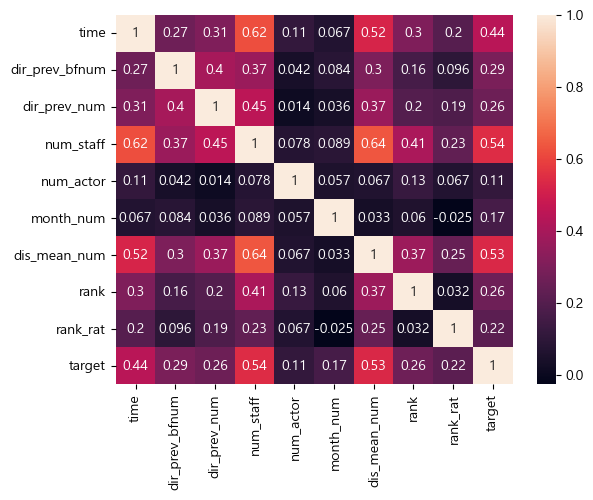

In [100]:
xtrain['target'] = ytrain
sns.heatmap(xtrain.corr(),annot=True)

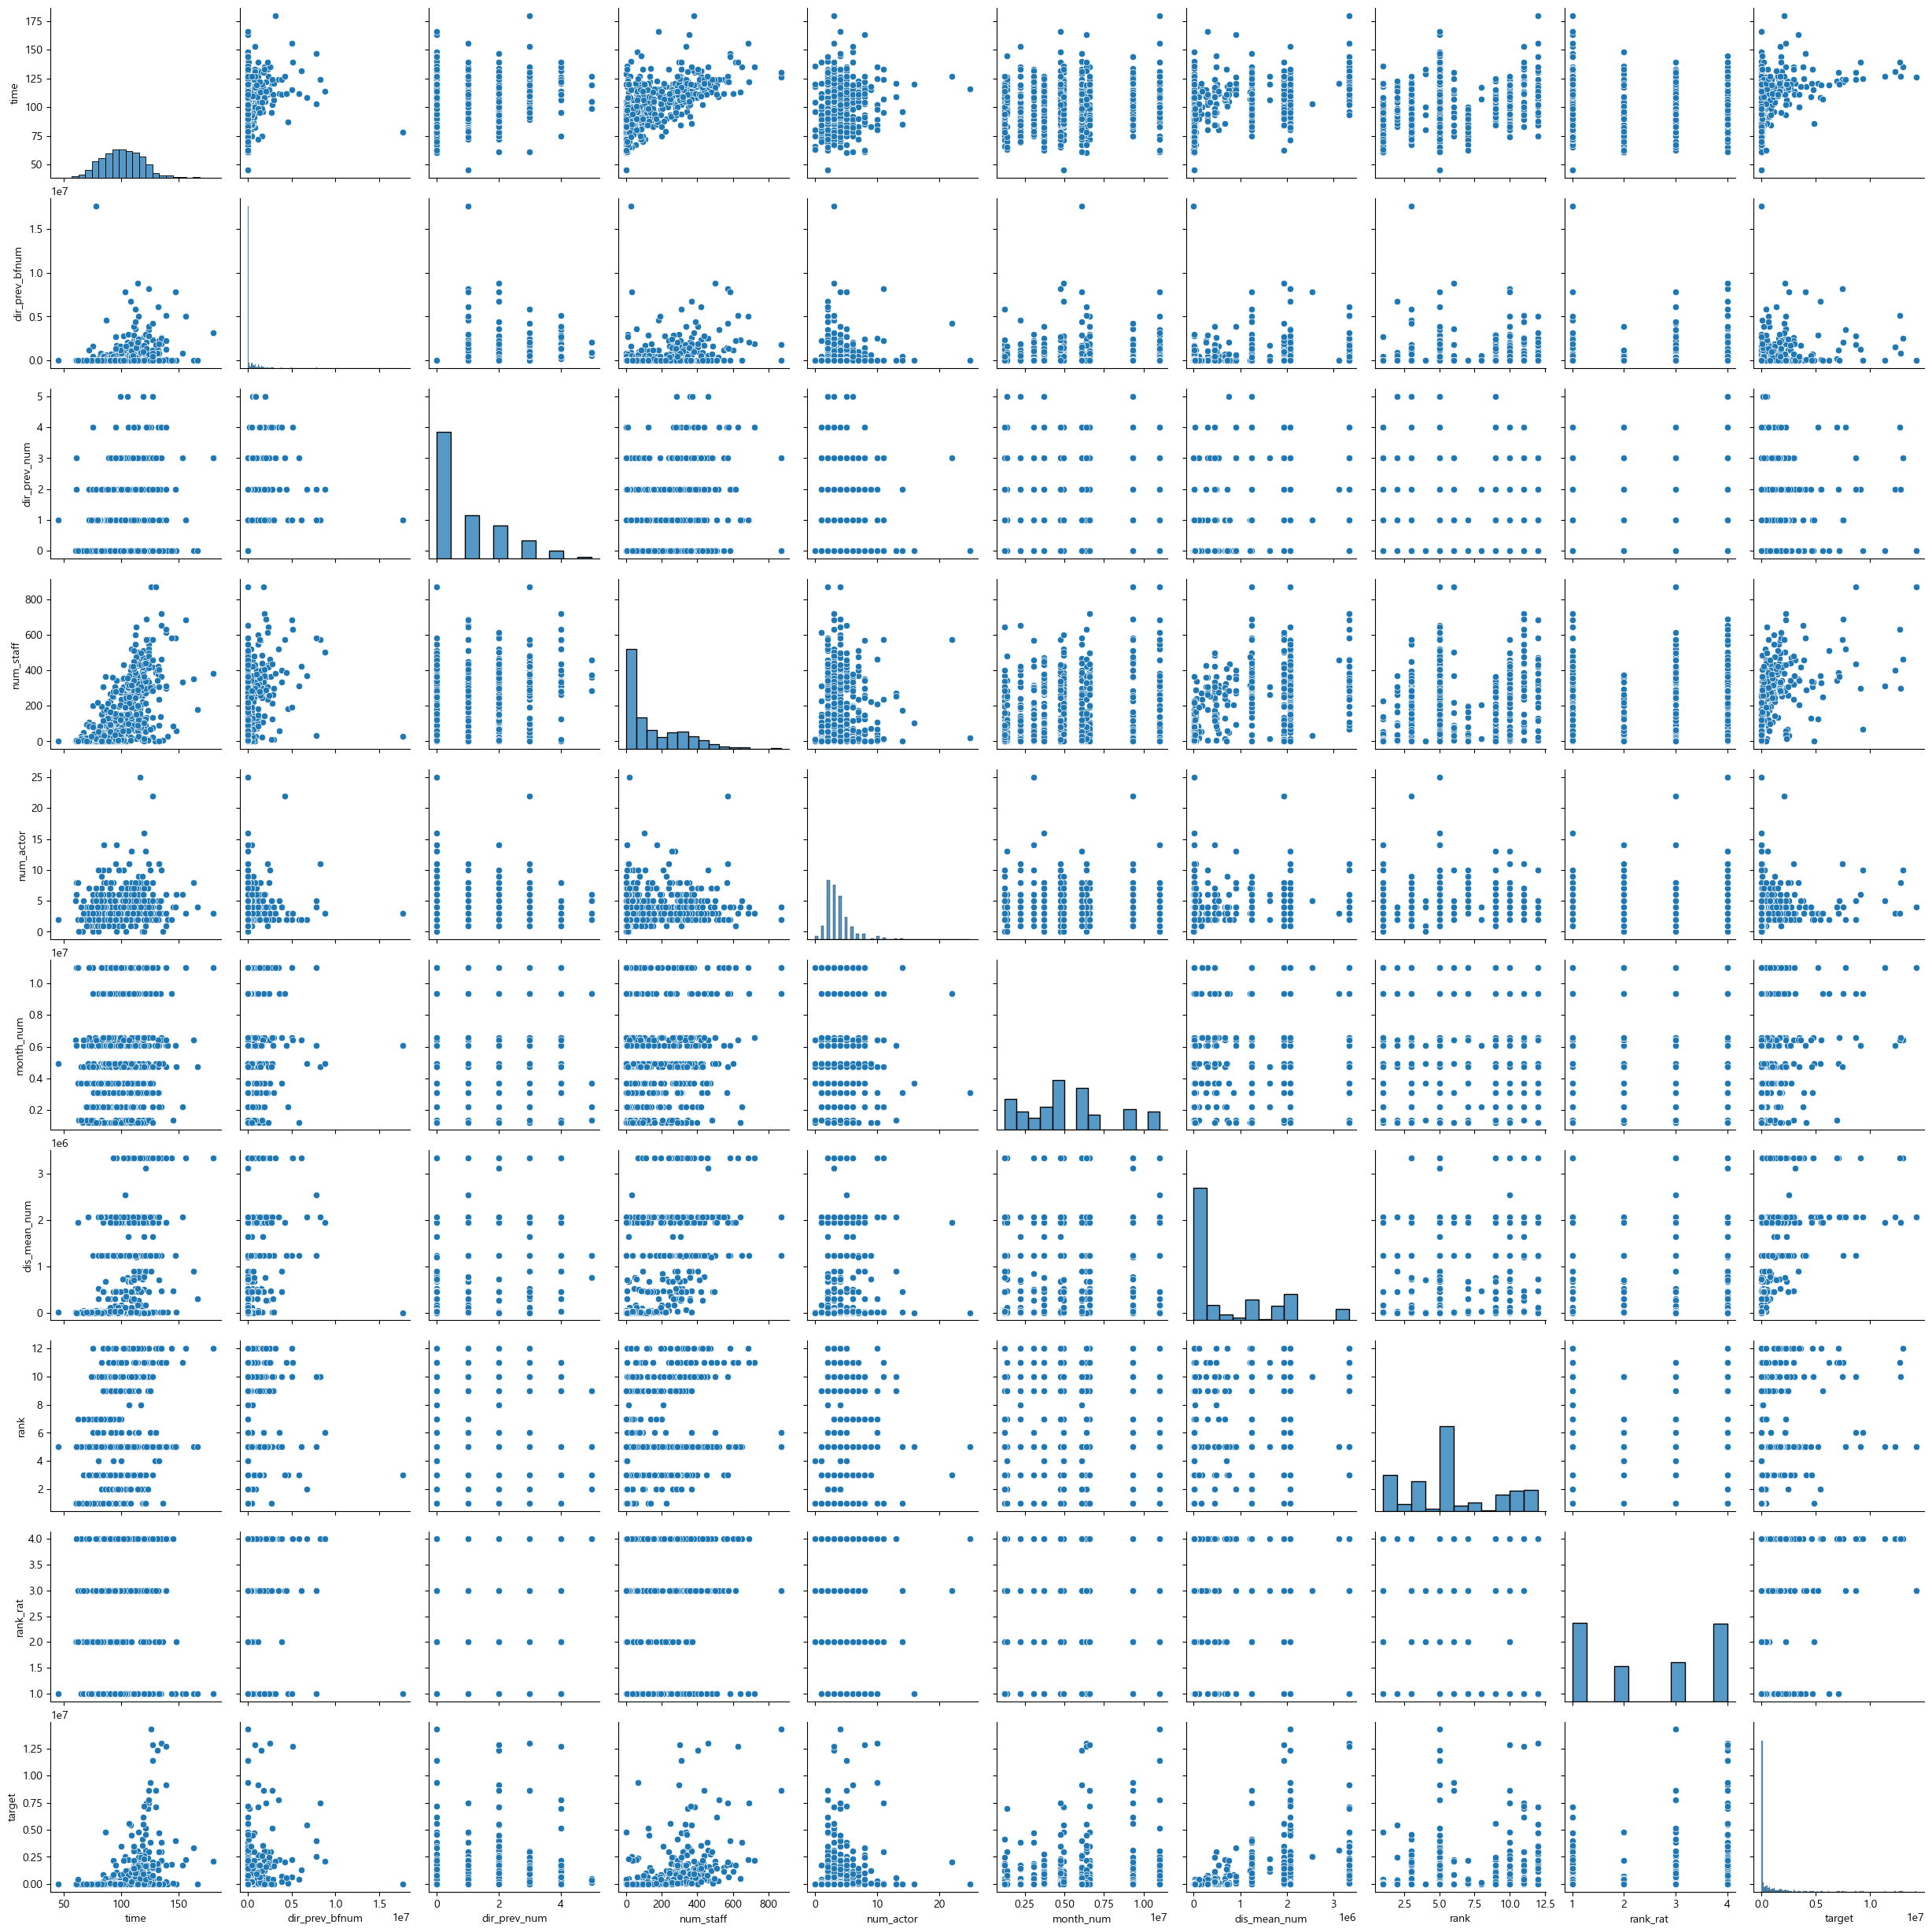

In [101]:
sns.pairplot(xtrain)

<AxesSubplot:>

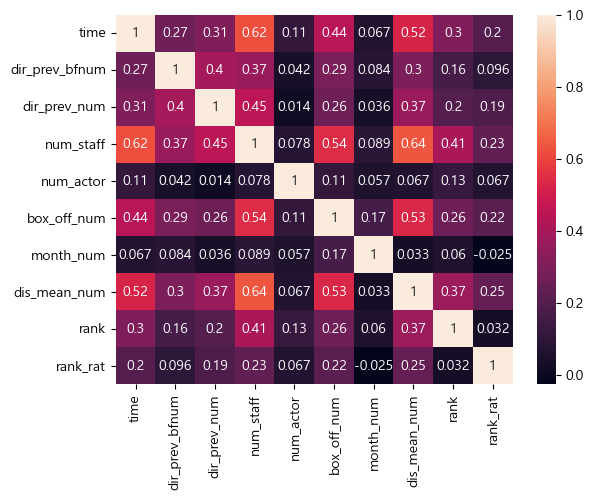

In [74]:
sns.heatmap(train.corr(), annot=True)

# temp test

In [132]:
scaler3

RobustScaler()

In [146]:
scaler2

StandardScaler()

In [143]:
model = RandomForestRegressor()

model.fit(scaler2.fit_transform(xtrain),np.log1p(ytrain))
pred = model.predict(scaler2.transform(test.fillna(0)))

In [145]:
sub['box_off_num'] = np.expm1(pred)
sub.to_csv("temp_new.csv",index=None)

In [138]:
np.log1p(ytrain)

0     10.06
1     15.77
2     15.76
3     12.29
4     13.09
       ... 
595   14.20
596   14.36
597    7.81
598   14.60
599   15.78
Name: box_off_num, Length: 600, dtype: float64

In [147]:
train2 = pd.read_csv('movies_train.csv')
test2 = pd.read_csv('movies_test.csv')
# sub = pd.read_csv('submission.csv')

In [158]:
train2=train2['distributor']
test2=test2['distributor']

In [161]:
len(train2.unique())

169

In [163]:
len(test2.unique())

93

In [166]:
'시네마서비스' in train2.unique()

True

In [168]:
for i in test2:
    print(i in train2.unique())

True
True
True
True
True
False
True
False
False
False
True
True
False
True
True
True
True
True
True
True
False
True
True
True
False
True
True
True
True
False
True
True
True
True
True
True
True
True
True
False
False
True
True
True
True
True
False
False
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
True
True
True
True
True
False
True
True
True
False
True
True
True
True
True
True
True
True
False
True
True
False
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [171]:
train2[train2=='(주)컨텐츠온미디어']

Series([], Name: distributor, dtype: object)

In [169]:
test2[-3:]

240     (주)컨텐츠온미디어
241    (주)씨타마운틴픽쳐스
242      (주) 케이알씨지
Name: distributor, dtype: object

In [153]:
new_list = []
for i in test2['distributor']:
    new_list.append(i in train2['distributor'].unique())
    #  in train2['distributor'].unique()

In [157]:
train2[train2['distributor']=='시네마서비스']

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
30,로맨틱 헤븐,시네마서비스,드라마,2011-03-24,117,12세 관람가,장진,NaN,0,369,7,73729
209,이끼,시네마서비스,드라마,2010-07-14,163,청소년 관람불가,강우석,NaN,0,353,8,3350311
273,퀴즈왕,시네마서비스,코미디,2010-09-16,121,15세 관람가,장진,NaN,0,273,13,573001
298,소수의견,시네마서비스,드라마,2015-06-24,126,15세 관람가,김성제,481722.75,4,287,3,383582
303,가비,시네마서비스,미스터리,2012-03-15,115,15세 관람가,장윤현,627301.67,3,95,4,270602
395,주유소 습격사건 2,시네마서비스,코미디,2010-01-21,111,15세 관람가,김상진,3907784.50,4,402,4,729834


In [154]:
test2[new_list]

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,300529.00,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,342700.25,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4206610.67,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,691342.00,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,31738.00,1,380,1
...,...,...,...,...,...,...,...,...,...,...,...
233,"나의 아들, 나의 어머니",인디플러그,다큐멘터리,2015-12-17,70,전체 관람가,안재민,3568.00,3,1,2
235,타이밍,(주)스톰픽쳐스코리아,애니메이션,2015-12-10,100,15세 관람가,민경조,NaN,0,56,1
237,어떤이의 꿈,하준사,드라마,2015-11-26,72,12세 관람가,조성규,NaN,0,29,3
239,울보 권투부,인디스토리,다큐멘터리,2015-10-29,86,12세 관람가,이일하,NaN,0,18,2
